In [1]:
#%matplotlib widget
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
from pathlib import Path

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
#rc('text', usetex=True)

> # **Analysis Code for the Edge Illumination Method:**

The following code provides the necessary tools to read `.raw` files and convert them into `.txt` files. The second part of the code performs the statistical analysis of the previously interpreted images, where the CNR (Contrast-to-Noise Ratio) and SNR (Signal-to-Noise Ratio) can be calculated using binary masks based on the region of interest (ROI) you want to evaluate.

> **Code for Reading the Raw Files:**

This first section contains the scripts used to read the `.raw` files. The structure followed by the code to read each image is as follows. A folder with any name is analyzed—for example, let’s assume we are studying the phantom case with a 10$\mu$m focal spot, named `Phantom_10um`.

As discussed in the manual, if we want the final image to have good visualization, dithering must be applied. Therefore, within `Phantom_10um`, there should be $N$ folders named with a single number from 1 to $N$, where $N$ is the number of dithering steps. Inside each of these folders, the `.raw` files must be located, and named following the format "Piece_X.raw", where $X$ corresponds to the number of `/Pepi/cont/beamOn` commands set at the start of the simulation.
For example, if two `/Pepi/cont/beamOn` commands were issued, then the resulting files should be named "Piece_1.raw" and "Piece_2.raw". The order does not matter. Lastly, the entire folder should be placed inside the "raw_files" directory.

If you collected Flat Field data, you must create another folder called `FF`, where you will follow the exact same structure as the mentioned above for any `/Pepi/cont/beamOn` made.

If all of this is correctly set up, the code should run without any issues. If this explanation is not sufficient, you can access the `raw_files` directory and inspect the structure of any of the example folders it contains.



In [2]:
def Matrix_Creator(Raw, Pixels):
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def DataImport(path, extension, Pixels, NRaw):
    data = []
    eff_num = 0

    # Fist, we compute the normal images taken from the simulation.
    try:
        for i in range(1, NRaw + 1):
            step = "{}_{}.raw".format(extension, i)
            Raw = np.fromfile(path / Path(step), dtype='float32')
            matrix = Matrix_Creator(Raw, Pixels)
            data.append(matrix)
        print("1. The dithering image {} has been succesfully ran with {} beamruns.".format(path, i))
    except Exception as e:
        print("1. The dithering image {} has only {} beamruns.".format(path, i - 1))
        print("{}".format(e))
        eff_num = i - 1
        None
        
    # This value represents the beamruns made for each set.
    if eff_num == 0:
        eff_num = NRaw
    else:
        None
    
    return data, eff_num

def ImageGenerator(data, N_images, N_Dopple):
    images = []
    for i in range(0, N_images):
        mean = 0
        for j in range(0, N_Dopple):
            mean += data[i][j]
        mean = mean/N_Dopple
        images.append(mean)  
    return images

def IntensityMean(image, Pixels, cut):
    intensity = np.zeros(Pixels)
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
    intensity = intensity[cut:-cut]
    mean = intensity/np.max(intensity)
    return mean


def Average(name,X1,X2,Step):
    P = np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2] = (1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

The `LoadingImages` function will be used to load the images. It takes the following parameters:

- `raw`: name of the folder where the subfolders containing the `.raw` files are stored. In our case, this will be `raw_files`.
- `directory`: name of the folder containing the `.raw` files of interest. Here, we provide an example showing how the phantom changes with different focal spots. We will use a folder named `Phantom_FS`.
- `variation`: name of the subfolder corresponding to the variation of interest. In the example above, if we want to observe how the image changes with the focal spot size, we can create a folder named after its value, e.g., `5um`. This folder plays the same role as `Phantom_10um` mentioned at the beginning of the notebook.
- `extension`: base name for the `.raw` files. The initial structure can be modified if needed. In our case, we chose to use `Piece`, but users are free to change it as they wish.
- `pixel`: assuming a square detector, this is the number of pixels along one side. In our case, we are working with a 256x256 pixel detector.
- `n_dithstep`: number of dithering steps used.
- `n_typeCOL`: selected detection type.
- `n_beamrun`: number of `/Pepi/cont/beamOn` commands executed. A high value can be set; the code will check how many files actually exist and will inform the user how many were successfully read.

In [3]:
def LoadingImages(raw, directory, variation, extension, pixel, n_dithstep, n_typeCOL, n_beamrun, normalize):
    images = []
    is_FF = False
    for i in range(1, n_dithstep + 1):
        print("----- Set #{} is being analyzed ------".format(i))
        number = str(i)
        path = Path(raw) / Path(directory) / Path(variation) / Path(number)
        data, eff_num = DataImport(path, extension, pixel, n_beamrun) 
        generated_images = ImageGenerator(data, eff_num, n_typeCOL + 1)
        image = np.zeros_like(generated_images[0])
        
        for j in generated_images:
            image += j
        images.append(image)
        print("----- Set #{} has been succesfully analyzed ------ \n".format(i))
    
    try:
        print("----- The Flat Field is being analyzed ------")
        ff_tag = "FF"
        path = Path(raw) / Path(directory) / Path(variation) / Path(ff_tag)
        ffdata, ffeff_num = DataImport(path, extension, pixel, n_beamrun)
        ffimages = ImageGenerator(ffdata, ffeff_num, n_typeCOL + 1)
        ffimage = np.zeros_like(ffimages[0])
        for k in ffimages:
            ffimage += k
        is_FF = True
        print("----- The Flat Field has been succesfully analyzed ------ \n")
        
    except Exception as e:
        print("There is no flat field available for this set.")
    
    # Normalization:
    if is_FF == True and normalize == True:
        try:
            for l in range(0, len(images)):
                images[l] = images[l]/ffimage
            print("The set of images was successfully normalized.")
        except Exception as e:
            print("The normalization was not possible due to ]an error: {}.".format(e))

    return images

In [106]:
pixel = 256
n_typeCOL = 1
n_dithstep = 4
n_beamrun = 2
raw = "raw_files"
txt = "txt_files"
directory = "Phantom_FS"
variation = "150um"
extension = "Piece"
study = "Phantom"

In [107]:
images = LoadingImages(raw, directory, variation, extension, pixel, n_dithstep, n_typeCOL, n_beamrun, True)

----- Set #1 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\150um\1 has been succesfully ran with 2 beamruns.
----- Set #1 has been succesfully analyzed ------ 

----- Set #2 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\150um\2 has been succesfully ran with 2 beamruns.
----- Set #2 has been succesfully analyzed ------ 

----- Set #3 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\150um\3 has been succesfully ran with 2 beamruns.
----- Set #3 has been succesfully analyzed ------ 

----- Set #4 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\150um\4 has been succesfully ran with 2 beamruns.
----- Set #4 has been succesfully analyzed ------ 

----- The Flat Field is being analyzed ------
1. The dithering image raw_files\Phantom_FS\150um\FF has been succesfully ran with 2 beamruns.
----- The Flat Field has been succesfully analyzed ------ 

The set of images was successfully normalized.


Here you can see the images. Change the value of `k` to navigate through all of the loaded images

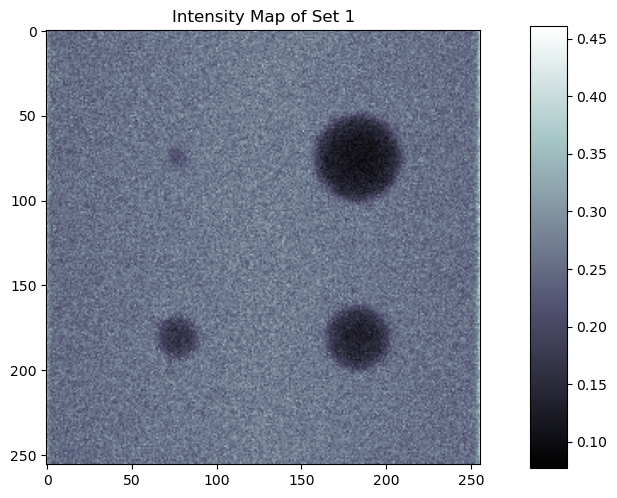

In [108]:
k = 0
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Intensity Map of Set {}".format(k + 1))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

The following graph is just a visualization of the intensity proyected on the X axis.

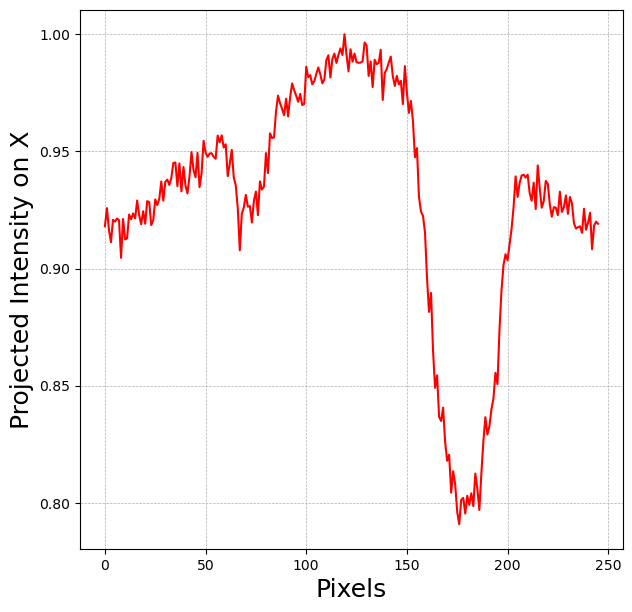

In [109]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = IntensityMean(images[k], pixel, 5)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 18)
ax.set_ylabel("Projected Intensity on X", fontsize = 18)
ax.grid(linestyle = '--', linewidth = 0.5)

This section saves all of the images as `.txt` files for easier manipulation later.

In [110]:
look_for = Path(txt) / Path(directory)
text_path = look_for / Path(variation)

def save_txt(look_for, text_path, images):
    try: 
        os.mkdir(look_for)
        print("Directory succesfully created. \n")
    except Exception as e:
        print("{}".format(e))
    
    try:
        os.mkdir(text_path)
        print("The sub-directory was succesfully created. \n")
    except Exception as e:
            print("{}".format(e))
    
    for i in range(1, n_dithstep + 1):
        if i == 1:
            print("\n ---- Saving the images in the {} folder ---- \n".format(text_path))
        name = "Frame_{}.txt".format(i)
        image_path = text_path / Path(name)
        np.savetxt(image_path, images[i - 1], fmt = "%.6f")
        if i == n_dithstep:
            print("\n ---- Images succesfully saved in the {} folder ---- \n".format(text_path))
    
    return None

In [111]:
save_txt(look_for, text_path, images)

[WinError 183] No se puede crear un archivo que ya existe: 'txt_files\\Phantom_FS'
[WinError 183] No se puede crear un archivo que ya existe: 'txt_files\\Phantom_FS\\150um'

 ---- Saving the images in the txt_files\Phantom_FS\150um folder ---- 


 ---- Images succesfully saved in the txt_files\Phantom_FS\150um folder ---- 



> # **Retrieval of the Absorption and Phase Maps:**

This section focuses on the retrieval of the absorption and phase maps from the previously acquired image. The code merges the images obtained at each dithering step and combines them into a single image.

In [112]:
z_FS = 0.6 
z_SD = 1.2 
z_FD = z_FS + z_SD 
M = z_FD/z_FS
E_J = 20 
h=6.63*10**(-34)
c=3*(10**(8))
k=(2*np.pi*E_J)/(h*c)
o = k/z_SD

a =  31.6*(10**(-6))

In [113]:
txt_images = []
for i in range(1, n_dithstep + 1):
    txt_im_path =  "Frame_{}.txt".format(i)
    image = np.genfromtxt(text_path / Path(txt_im_path))
    txt_images.append(image)

In [114]:
def CreatingMaps(txt_images):
    Odd_Maps = []
    Even_Maps =[]
    Absor_Maps = []
    Phase_Maps = []

    for i in range(0, n_dithstep): 
        odd = txt_images[i][:,1::2] 
        even = txt_images[i][:,::2]
        
        absor = (txt_images[i][:,::2] + txt_images[i][:,1::2])/2
        p_num = txt_images[i][:,1::2] - txt_images[i][:,::2]
        d_num = txt_images[i][:,1::2] + txt_images[i][:,::2]
        phase  = (M*a*o/2)*np.divide(p_num, d_num, out = np.zeros_like(p_num), where = d_num != 0)
        
        Odd_Maps.append(odd)
        Even_Maps.append(even)
        Absor_Maps.append(absor)
        Phase_Maps.append(phase)


    Sep = int(pixel/2)
    shortener = 5

    Odd_Dith = np.zeros((pixel, n_dithstep*Sep))
    Even_Dith = np.zeros((pixel, n_dithstep*Sep))
    Absor_Dith = np.zeros((pixel, n_dithstep*Sep))
    Phase_Dith = np.zeros((pixel, n_dithstep*Sep))

    for i in range(0, n_dithstep):
        for j in range(0, int(pixel/2)):
            Odd_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Odd_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Even_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Even_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Absor_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Absor_Maps[n_dithstep - 1 - i][:,j:j + 1]
            Phase_Dith[:, n_dithstep*j + i:n_dithstep*j + i + 1] = Phase_Maps[n_dithstep - 1 - i][:,j:j + 1]

    Factor = Odd_Dith.shape[1]/Odd_Dith.shape[0]

    Odd = zoom(Odd_Dith, (Factor, 1))
    Even = zoom(Even_Dith, (Factor, 1))
    Absor= zoom(Absor_Dith, (Factor, 1))
    Phase = zoom(Phase_Dith, (Factor, 1))

    Odd = Odd/np.max(Odd)
    Even = Even/np.max(Even)
    Absor = Absor/np.max(Absor)
    Phase = Phase/np.max(Phase)

    Total = (Even + Odd)/np.max(Even + Odd)

    IC_Absor = IntensityMean(Absor, Absor.shape[0], shortener)
    IC_Phase = IntensityMean(Phase, Phase.shape[0], shortener)
    IC_Total = IntensityMean(Total, Total.shape[0], shortener)


    return {"Absortion Map:":(Absor, IC_Absor), "Phase Map:":(Phase, IC_Phase), "Total Map:":(Total, IC_Total)}

In [115]:
Images_Maps = CreatingMaps(txt_images)

In [116]:
Absor = Images_Maps["Absortion Map:"][0]
IC_Absor = Images_Maps["Absortion Map:"][1]
Phase = Images_Maps["Phase Map:"][0]
IC_Phase = Images_Maps["Phase Map:"][1]
Total = Images_Maps["Total Map:"][0]
IC_Total = Images_Maps["Total Map:"][1]

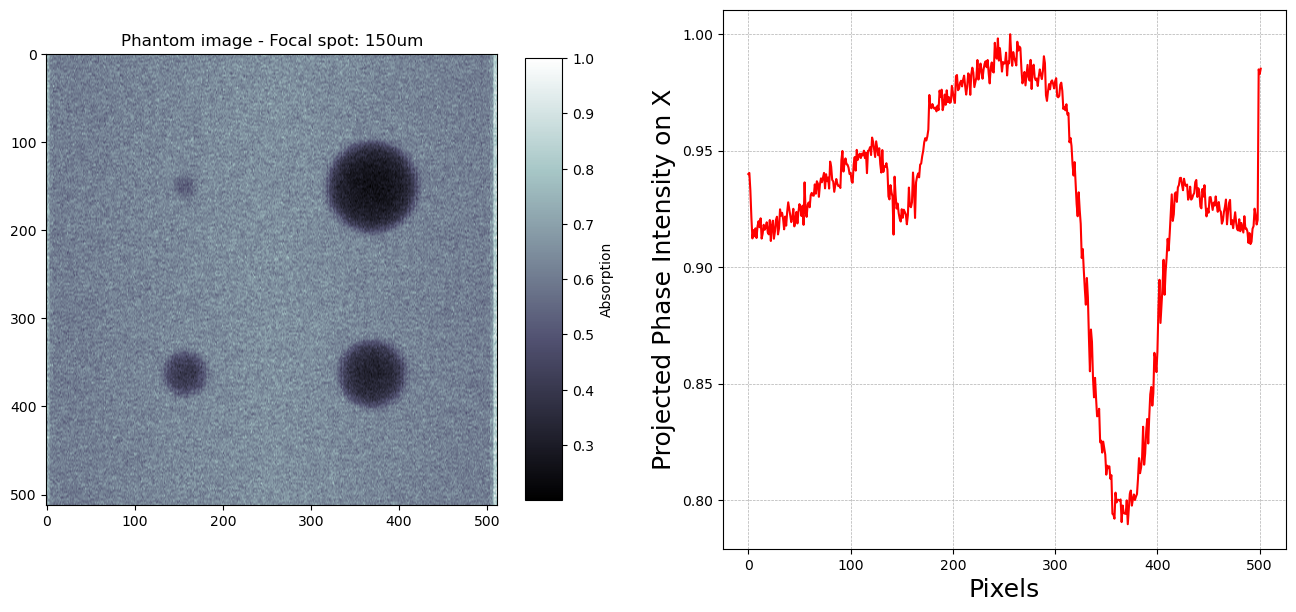

In [117]:
fig, ax = plt.subplots(ncols = 2, figsize=(16, 7))

map_ = ax[0].imshow(Absor, cmap = "bone")
ax[0].set_title("{} image - Focal spot: {}".format(study, variation))
cbar = fig.colorbar(map_, ax=ax[0], location='right', shrink=0.82, aspect=12)
cbar.set_label("Absorption", fontsize=10)


ax[1].plot(IC_Absor, '-', color="red")
ax[1].set_xlabel("Pixels", fontsize = 18)
ax[1].set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax[1].grid(linestyle = '--', linewidth = 0.5)

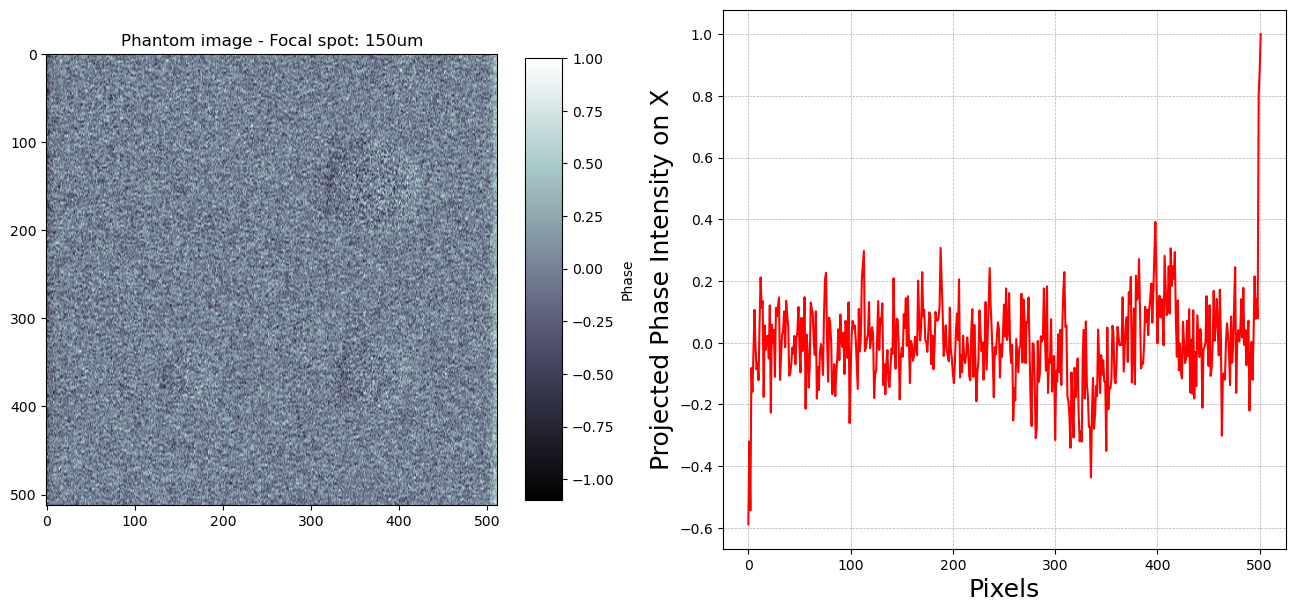

In [118]:
fig, ax = plt.subplots(ncols = 2, figsize=(16, 7))
map_ = ax[0].imshow(Phase, cmap = "bone")
ax[0].set_title("{} image - Focal spot: {}".format(study, variation))
cbar = fig.colorbar(map_, ax=ax[0], location='right', shrink=0.82, aspect=12)
cbar.set_label("Phase", fontsize=10)

ax[1].plot(IC_Phase, '-', color="red")
ax[1].set_xlabel("Pixels", fontsize = 18)
ax[1].set_ylabel("Projected Phase Intensity on X", fontsize = 18)
ax[1].grid(linestyle = '--', linewidth = 0.5)

> ## **Creation of Images Array**

In [102]:
variation_array = ["10um", "40um", "50um", "55um", "100um", "150um", "200um"]


maps = []
for i in variation_array:
    
    images = LoadingImages(raw, directory, i, extension, pixel, n_dithstep, n_typeCOL, n_beamrun, False)
    
    text_path = look_for / Path(i)
    save_txt(look_for, text_path, images)
    txt_images = []

    for j in range(1, n_dithstep + 1):

        txt_im_path =  "Frame_{}.txt".format(j)

        image = np.genfromtxt(text_path / Path(txt_im_path))
        txt_images.append(image)

    map = CreatingMaps(txt_images)
    
    maps.append(map)

----- Set #1 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\10um\1 has been succesfully ran with 2 beamruns.
----- Set #1 has been succesfully analyzed ------ 

----- Set #2 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\10um\2 has been succesfully ran with 2 beamruns.
----- Set #2 has been succesfully analyzed ------ 

----- Set #3 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\10um\3 has been succesfully ran with 2 beamruns.
----- Set #3 has been succesfully analyzed ------ 

----- Set #4 is being analyzed ------
1. The dithering image raw_files\Phantom_FS\10um\4 has been succesfully ran with 2 beamruns.
----- Set #4 has been succesfully analyzed ------ 

----- The Flat Field is being analyzed ------
1. The dithering image raw_files\Phantom_FS\10um\FF has been succesfully ran with 2 beamruns.
----- The Flat Field has been succesfully analyzed ------ 

[WinError 183] No se puede crear un archivo que ya existe: 'txt_file

In [123]:
def plot_images_grid(rows, cols, images, titles=None, main_title=None, bar_title=None, figsize=(10, 5), cmap='bone'):

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.flatten() if rows * cols > 1 else [axs]

    for i in range(rows * cols):

        ax = axs[i]
        if i < len(images):
            im = ax.imshow(images[i], cmap)
            
            if titles is not None and i < len(titles):
                ax.set_title(titles[i])

            cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.82, aspect=12)
            cbar.set_label(bar_title, fontsize=8)

        ax.axis('off')
    
    if main_title is not None:
        fig.suptitle(main_title, fontsize=14)

    plt.tight_layout()
    plt.show()
    return fig, axs

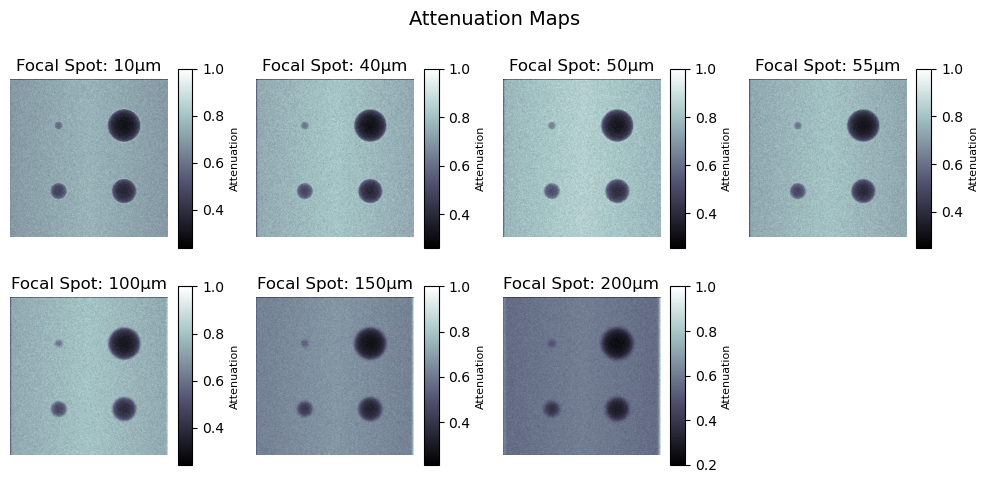

(<Figure size 1000x500 with 15 Axes>,
 array([<Axes: title={'center': 'Focal Spot: 10μm'}>,
        <Axes: title={'center': 'Focal Spot: 40μm'}>,
        <Axes: title={'center': 'Focal Spot: 50μm'}>,
        <Axes: title={'center': 'Focal Spot: 55μm'}>,
        <Axes: title={'center': 'Focal Spot: 100μm'}>,
        <Axes: title={'center': 'Focal Spot: 150μm'}>,
        <Axes: title={'center': 'Focal Spot: 200μm'}>, <Axes: >],
       dtype=object))

In [124]:
titles = [f'Focal Spot: {i[:-2]}μm' for i in variation_array]

plot_images_grid(2, 4, [att['Absortion Map:'][0] for att in maps], titles, "Attenuation Maps", "Attenuation")

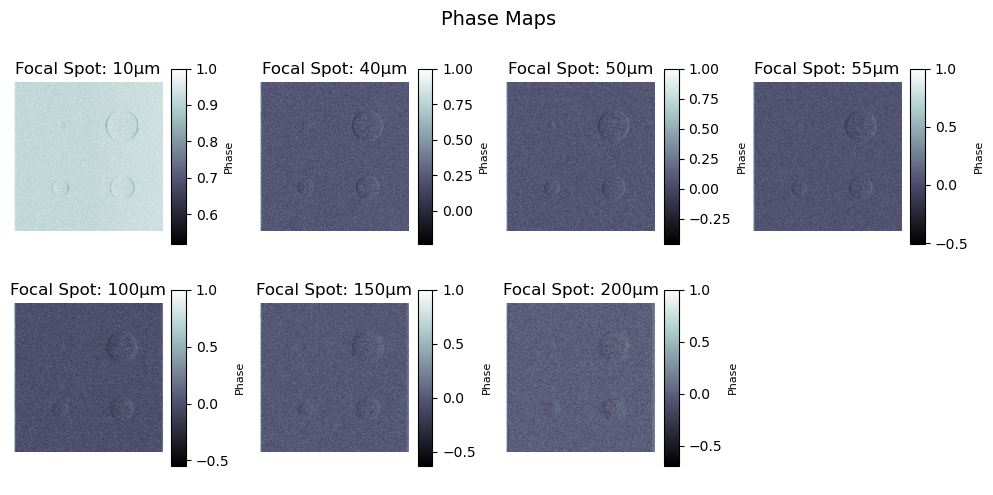

(<Figure size 1000x500 with 15 Axes>,
 array([<Axes: title={'center': 'Focal Spot: 10μm'}>,
        <Axes: title={'center': 'Focal Spot: 40μm'}>,
        <Axes: title={'center': 'Focal Spot: 50μm'}>,
        <Axes: title={'center': 'Focal Spot: 55μm'}>,
        <Axes: title={'center': 'Focal Spot: 100μm'}>,
        <Axes: title={'center': 'Focal Spot: 150μm'}>,
        <Axes: title={'center': 'Focal Spot: 200μm'}>, <Axes: >],
       dtype=object))

In [125]:
titles = [f'Focal Spot: {i[:-2]}μm' for i in variation_array]

plot_images_grid(2, 4, [att['Phase Map:'][0] for att in maps], titles, "Phase Maps", "Phase")

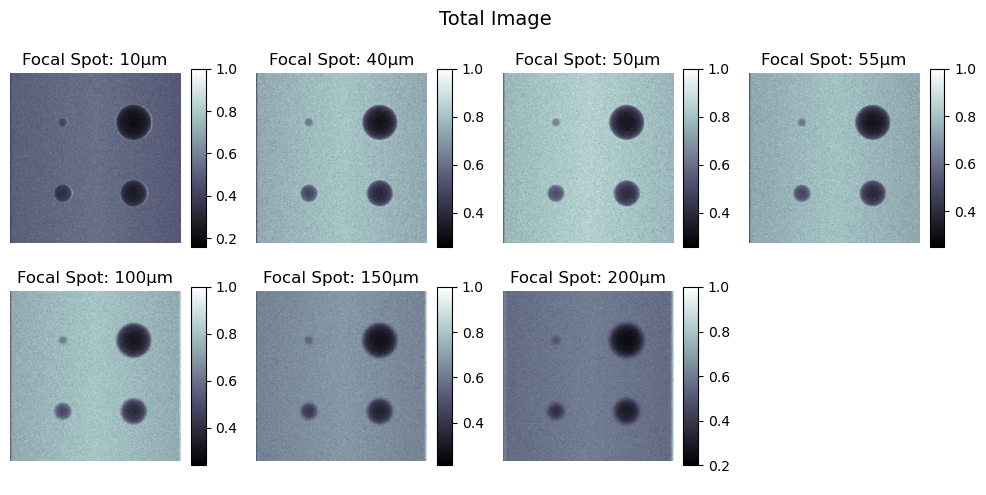

(<Figure size 1000x500 with 15 Axes>,
 array([<Axes: title={'center': 'Focal Spot: 10μm'}>,
        <Axes: title={'center': 'Focal Spot: 40μm'}>,
        <Axes: title={'center': 'Focal Spot: 50μm'}>,
        <Axes: title={'center': 'Focal Spot: 55μm'}>,
        <Axes: title={'center': 'Focal Spot: 100μm'}>,
        <Axes: title={'center': 'Focal Spot: 150μm'}>,
        <Axes: title={'center': 'Focal Spot: 200μm'}>, <Axes: >],
       dtype=object))

In [129]:
titles = [f'Focal Spot: {i[:-2]}μm' for i in variation_array]

plot_images_grid(2, 4, [att['Total Map:'][0] for att in maps], titles, "Total Image")

> ## **Calculation of Signal-to-Noise and Contrast-to-Noise Ratios**

In [64]:
def SNR_and_CNR(mask, mask_back, image):
    try:
        if mask_back is None:
            mask_back = 1 - mask
    except:
        None


    ROI_Signal = image[mask == 1]
    BackG_Signal = image[mask_back == 1]


    Mean_ROI = np.mean(ROI_Signal)
    Std_ROI = np.std(ROI_Signal, ddof=1)

    Mean_BackG = np.mean(BackG_Signal)
    Std_BackG = np.std(BackG_Signal, ddof=1)

    Nsignal = len(ROI_Signal)
    NbackG = len(BackG_Signal)

    # --------- SNR ----------
    SNR = Mean_ROI / Std_ROI
    dMean_ROI = Std_ROI / np.sqrt(Nsignal)
    dStd_ROI = Std_ROI / np.sqrt(2 * (Nsignal - 1))
    errSNR = SNR * np.sqrt((dMean_ROI / Mean_ROI)**2 + (dStd_ROI / Std_ROI)**2)

    # --------- CNR ----------
    CNR = np.abs(Mean_ROI - Mean_BackG) / Std_BackG
    dMean_BackG = Std_BackG / np.sqrt(NbackG)
    dStd_BackG = Std_BackG / np.sqrt(2 * (NbackG - 1))

    errCNR = CNR * np.sqrt(
        (dMean_ROI**2 + dMean_BackG**2) / (Mean_ROI - Mean_BackG)**2 +
        (dStd_BackG / Std_BackG)**2
    )

    return SNR, errSNR, CNR, errCNR


> # **Binary Mask of the Mammographic Phantom**

In [65]:
if  study == "Phantom":
    # Binary Mask of the Phantom:
    scale = 2
    delta = 0

    # Image dimensions:
    height, width = 256, 256

    # Sphere centers:
    center_x1, center_y1  = 79, 75 # Sphere 1
    center_x2, center_y2 = 79, 182 # Sphere 2
    center_x3, center_y3 = 185, 74 # Sphere 3
    center_x4, center_y4 = 185, 181 # Sphere 4

    # Radius:
    radius1 = 12 + delta # Located at 0, 0
    radius2 = 25 + delta # Located at 1, 0
    radius3 = 48 + delta # Located at 0, 1
    radius4 = 36 + delta # Located at 1, 1

    # Coordinates set:
    Y, X = np.ogrid[:height*scale, :width*scale]

    # Bodies construction:
    mask1 = ((X - center_x1*scale)**2 + (Y - center_y1*scale)**2) <= (radius1)**2
    mask2 = ((X - center_x2*scale)**2 + (Y - center_y2*scale)**2) <= (radius2)**2
    mask3 = ((X - center_x3*scale)**2 + (Y - center_y3*scale)**2) <= (radius3)**2
    mask4 = ((X - center_x4*scale)**2 + (Y - center_y4*scale)**2) <= (radius4)**2

    # Creating the masks:
    mask1 = mask1.astype(np.uint8)
    mask2 = mask2.astype(np.uint8)
    mask3 = mask3.astype(np.uint8)
    mask4 = mask4.astype(np.uint8)
    mask = mask1 + mask2 + mask3 + mask4
    mask_back = None
    Set = ["10um", "40um", "50um", "55um", "100um", "150um", "200um"] # Phantom_FS

> # **Binary Mask of the Tube:**

In [66]:
if study == "Tube":
    height, width = 512, 512
    shape = (height, width)

    mask_background = np.zeros(shape, dtype = bool)
    mask_intermediate = np.zeros(shape, dtype = bool)
    mask_inner = np.zeros(shape, dtype = bool)

    background_xi, background_xf, background_yi, background_yf = 50, 472, 0, 512

    intermediate1_xi, intermediate1_xf, intermediate1_yi, intermediate1_yf = 0, 50, 0, 512
    intermediate2_xi, intermediate2_xf, intermediate2_yi, intermediate2_yf = 472, 512, 0, 512
    intermediate3_xi, intermediate3_xf, intermediate3_yi, intermediate3_yf = 155, 360, 0, 512

    inner_xi, inner_xf, inner_yi, inner_yf = 155, 360, 0, 512

    mask_background[background_yi:background_yf, background_xi:background_xf] = True
    mask_background = 1 - mask_background

    mask_intermediate[intermediate1_yi:intermediate1_yf, intermediate1_xi:intermediate1_xf] = True
    mask_intermediate[intermediate2_yi:intermediate2_yf, intermediate2_xi:intermediate2_xf] = True
    mask_intermediate[intermediate2_yi:intermediate3_yf, intermediate3_xi:intermediate3_xf] = True
    mask_intermediate = 1 - mask_intermediate

    mask_inner[inner_yi:inner_yf, inner_xi:inner_xf] = True
    mask_inner = 1 - mask_inner

    mask = mask_inner
    mask_back = mask_background
    Set = ["5um", "10um", "50um", "100um", "150um", "200um"] # Tubes_All
    

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

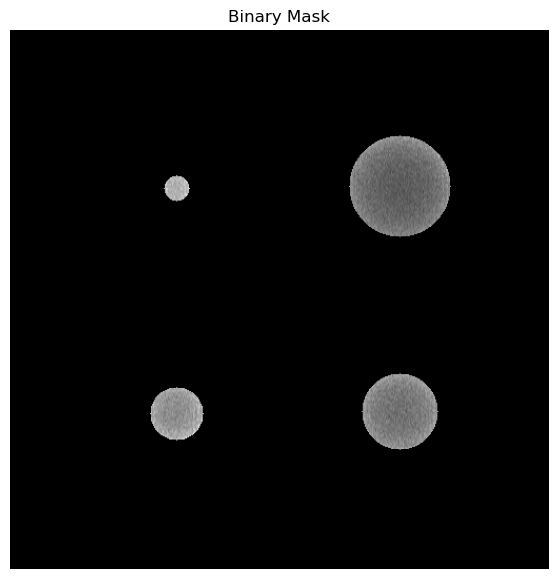

In [67]:
# Showing the ROI : Region of Interests
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mask*Absor, cmap='gray')
ax.set_title('Binary Mask')
ax.axis('off')

In [68]:
SNR_and_CNR(mask, None, Phase)

(np.float64(40.993179831069604),
 np.float64(0.2480951537703418),
 np.float64(0.095954492150663),
 np.float64(0.009985402923484127))

In [69]:
x_axis = []
for i in range(0, len(Set)):
    number = int(Set[i].replace("um", ""))
    x_axis.append(number)


SNR_absvalues = []
CNR_absvalues = []
SNR_abserrors = []
CNR_abserrors = []

SNR_phvalues = []
CNR_phvalues = []

for focal_spot in Set:
    images = LoadingImages(raw, directory, focal_spot, extension, pixel, n_dithstep, n_typeCOL, n_beamrun, False)
    images_maps = CreatingMaps(images)
    
    absortion = images_maps["Absortion Map:"][0]
    phase = images_maps["Phase Map:"][0]
    
    SNR_abs, errSNR_abs, CNR_abs, errCNR_abs = SNR_and_CNR(mask, mask_back, absortion)
    SNR_ph, errSNR_ph, CNR_ph, errCNR_ph = SNR_and_CNR(mask, None, phase)
    
    SNR_absvalues.append(SNR_abs)
    CNR_absvalues.append(CNR_abs)

    SNR_abserrors.append(errSNR_abs)
    CNR_abserrors.append(errCNR_abs)

    SNR_phvalues.append(SNR_ph)
    CNR_phvalues.append(CNR_ph)

----- Set #1 is being analyzed ------
1. The dithering image raw_files/Phantom_FS/10um/1 has been succesfully ran with 2 beamruns.
----- Set #1 has been succesfully analyzed ------ 

----- Set #2 is being analyzed ------
1. The dithering image raw_files/Phantom_FS/10um/2 has been succesfully ran with 2 beamruns.
----- Set #2 has been succesfully analyzed ------ 

----- Set #3 is being analyzed ------
1. The dithering image raw_files/Phantom_FS/10um/3 has been succesfully ran with 2 beamruns.
----- Set #3 has been succesfully analyzed ------ 

----- Set #4 is being analyzed ------
1. The dithering image raw_files/Phantom_FS/10um/4 has been succesfully ran with 2 beamruns.
----- Set #4 has been succesfully analyzed ------ 

----- The Flat Field is being analyzed ------
1. The dithering image raw_files/Phantom_FS/10um/FF has been succesfully ran with 2 beamruns.
----- The Flat Field has been succesfully analyzed ------ 

----- Set #1 is being analyzed ------
1. The dithering image raw_fil

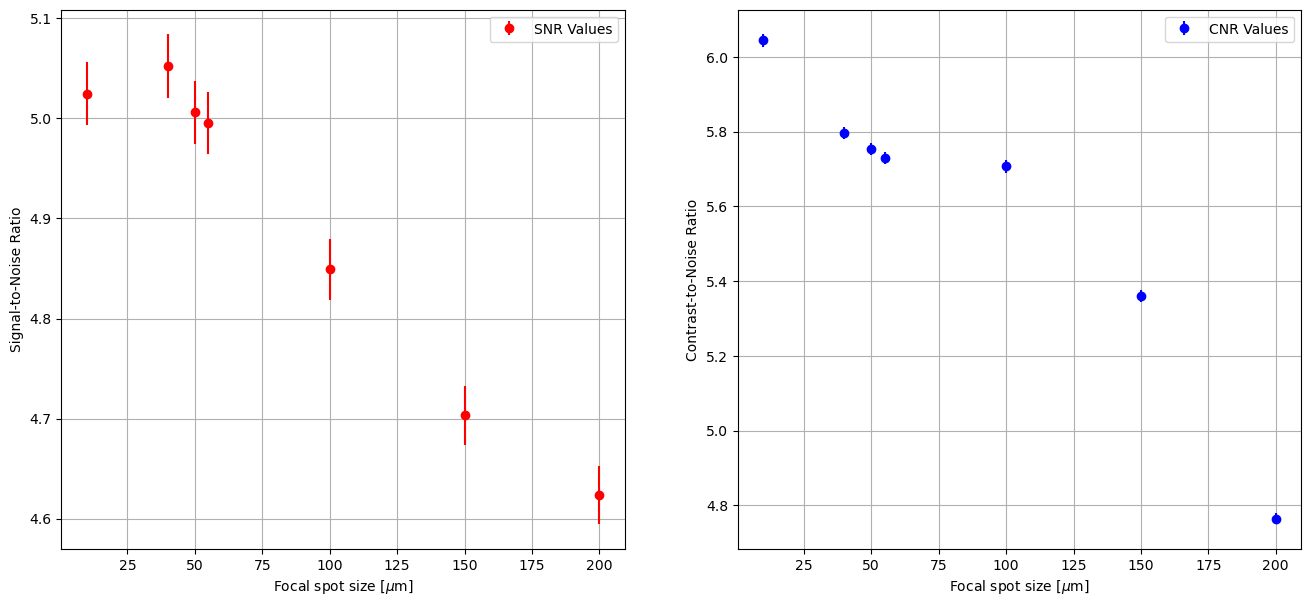

In [70]:
fig, ax = plt.subplots(ncols = 2, figsize=(16, 7))
ax[0].grid(True)
ax[1].grid(True)

ax[0].errorbar(x_axis, SNR_absvalues, yerr = SNR_abserrors, fmt = "o", color = "red", label = "SNR Values")
ax[1].errorbar(x_axis, CNR_absvalues, yerr = CNR_abserrors, fmt = "o", color = "blue", label = "CNR Values")

ax[0].set_xlabel(r"Focal spot size [$\mu$m]")
ax[0].set_ylabel(r"Signal-to-Noise Ratio")

ax[1].set_xlabel(r"Focal spot size [$\mu$m]")
ax[1].set_ylabel(r"Contrast-to-Noise Ratio")

ax[0].legend()
ax[1].legend()